In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.shape

(1460, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
missing = df.isna().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [6]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [7]:
df.shape

(1460, 76)

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
df.shape

(1094, 76)

In [10]:
numerical_features = [x for x in df.columns if df.dtypes[x] != 'object']
numerical_features.remove('Id')
# numerical_features

In [11]:
categorical_features = [x for x in df.columns if df.dtypes[x] == 'object']

In [12]:
for feature in categorical_features:
    df[feature] = df[feature].astype('category')
    df[feature] = df[feature].cat.codes

In [156]:
df_train = df[df.SalePrice <= 353750]
X = np.array(df_train.drop(['Id', 'SalePrice'], axis=1))
X.shape

(1044, 74)

In [157]:
y = np.array(df_train['SalePrice'])
y.shape

(1044,)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [159]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [160]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MSE: 692727896.9805144
MAE: 19239.323921682735
MAPE: 0.11949474908718016
R2_train: 0.8489393509908894
R2_test: 0.8183733518288423


In [161]:
model = Lasso(alpha=1600)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MSE: 669419210.3308206
MAE: 19001.87508491838
MAPE: 0.11683930769192301
R2_train: 0.8302265213135334
R2_test: 0.8244846671777819


In [162]:
model = Ridge(alpha=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MSE: 672015523.6066384
MAE: 18917.728630520567
MAPE: 0.1147253248789869
R2_train: 0.835545418796972
R2_test: 0.8238039385974193


In [163]:
model = ElasticNet(alpha=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100:.2f}%')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MSE: 673431130.5081483
MAE: 18933.51204914382
MAPE: 11.48%
R2_train: 0.834910806859272
R2_test: 0.8234327799682233


In [164]:
model = HuberRegressor(alpha=0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred) * 100:.2f}%')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MSE: 448692771.9969204
MAE: 15730.699858558979
MAPE: 9.83%
R2_train: 0.7655519937368475
R2_test: 0.8823570342819347


In [154]:
df.SalePrice.describe()

count      1094.000000
mean     187033.263254
std       83165.332151
min       35311.000000
25%      132500.000000
50%      165750.000000
75%      221000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot: ylabel='Frequency'>

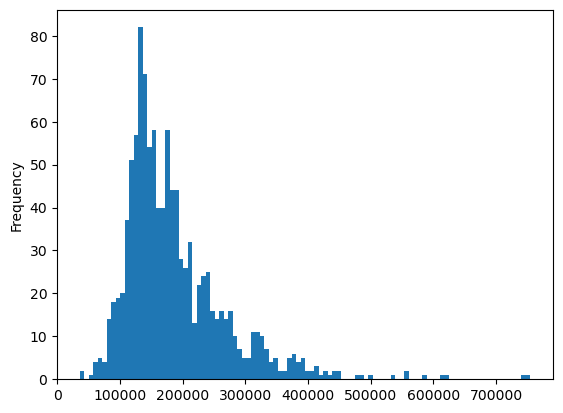

In [155]:
df.SalePrice.plot(kind='hist', bins=100)

In [ ]:
# import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
# tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
# sns.despine(offset=10, trim=True)

<AxesSubplot: >

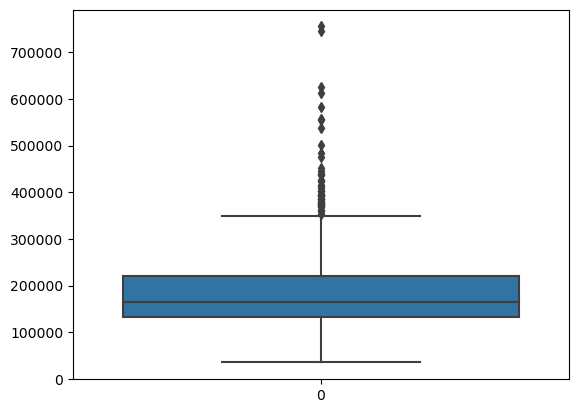

In [165]:
sns.boxplot(df.SalePrice)